<a href="https://colab.research.google.com/github/ELehmann91/NLP/blob/master/sdg_bert_classification_domain_adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train an SDG Classifier using the Hugging Face (Hub) Training Notebook and annotated Data from OSGD (https://osdg.ai/)

In this notebook we'll take a look at fine-tuning a multilingual Transformer model called [XLM-RoBERTa](https://huggingface.co/xlm-roberta-base) for text classification. By the end of this notebook you should know how to:

* Load and process a dataset from the Hugging Face Hub
* Create a baseline with the zero-shot classification pipeline
* Fine-tune and evaluate pretrained model on your data
* Push a model to the Hugging Face Hub

Let's get started!

In [1]:
%%capture
! pip install datasets transformers sentencepiece huggingface_hub
! apt install git-lfs

To be able to share your model with the community there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up here if you haven't already!) then execute the following cell and input your username and password:

In [48]:
!git config --global credential.helper store

In [5]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [6]:
!git config --global credential.helper store

## The dataset

In [7]:
#In this notebook we'll be using the 🤗 Datasets to load and preprocess our data. If you're new to this library, check out the video below to get some additional context:

In [8]:
import pandas as pd
df_osdg = pd.read_csv('https://zenodo.org/record/5550238/files/osdg-community-dataset-v21-09-30.csv',sep='\t')

In [9]:
print(df_osdg.shape)
df_osdg[:3]

(32120, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286


In [10]:
print(df_osdg.shape)
df_osdg[:3]

(32120, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286


In [ ]:
df_osdg = df_osdg[df_osdg['agreement']>.95]
print(df_osdg.shape)

(14754, 7)


In [ ]:
for i in range(101,105):
  print(df_osdg.iloc[i]['text'])
  print(df_osdg.iloc[i]['sdg'])

These studies examined the increasing participation levels of Asian women in business ownership. An interesting finding of the researches in the United Kingdom (Dhaliwal, 1998 and 2007; Ram and Jones, 1998) is that Asian women are not strongly represented in self-employment because there is a tendency for some women entrepreneurs to be “invisible” and their existence unacknowledged. These “hidden” women (Dhaliwal, 1998) say it is their husband, father or brother who run the business and they are masking the extent of their role even if they are playing a pivotal role in the management of the business.
5
For the case studies, national definitions of smallholder will be considered. These definitions emphasise income sources and the ability of farm households to transition either into commercially successful farm operations or out of farming altogether. Sometimes the definition includes a minimum share of farm labour that is contributed by the farmer’s family (FAO, 2014).
2
The existence 

In [ ]:
df_osdg.iloc[3]['sdg']

2

In [ ]:
df_osdg['sdg'].value_counts()

5     2607
4     2438
3     1845
7     1664
6     1457
11    1242
1     1239
13    1176
2      970
8      843
14     714
9      652
15     539
10     443
12     237
Name: sdg, dtype: int64

In [ ]:
df_osdg['lang'] = [te[-2:] for te in list(df_osdg['doi'])]
df_osdg['lang'].value_counts()

en    18023
r3       19
jb       11
d8        4
lt        3
9x        3
bn        2
q6        1
Name: lang, dtype: int64

In [ ]:
len_lst = []
for t in range(0,2000):
  text = df_osdg.iloc[t]['text']
  len_lst.append(len(text.split()))

In [ ]:
import numpy as np
np.quantile(len_lst,.9)

134.0

In [ ]:
#df_osdg['label'] = df_osdg['sdg']
#df_osdg['sdg'] = [str(a) for a in list(df_osdg['label'])]

df_osdg['sdg'] = df_osdg['sdg'].apply(lambda x: 'sdg_'+str(x))

In [ ]:
df_osdg.describe()

,labels_negative,labels_positive,agreement
count,18066.000000,18066.000000,18066.000000
mean,0.663290,4.836046,0.951245
std,6.207737,15.264043,0.104111
min,0.000000,0.000000,0.636364
25%,0.000000,3.000000,1.000000
50%,0.000000,4.000000,1.000000
75%,0.000000,6.000000,1.000000
max,777.000000,864.000000,1.000000


In [ ]:
df_osdg['sdg'].value_counts()

sdg_5     2607
sdg_4     2438
sdg_3     1845
sdg_7     1664
sdg_6     1457
sdg_11    1242
sdg_1     1239
sdg_13    1176
sdg_2      970
sdg_8      843
sdg_14     714
sdg_9      652
sdg_15     539
sdg_10     443
sdg_12     237
Name: sdg, dtype: int64

In [ ]:
from datasets import Dataset
dataset =  Dataset.from_pandas(df_osdg)

In [ ]:
dataset

Dataset({
    features: ['doi', 'text_id', 'text', 'sdg', 'labels_negative', 'labels_positive', 'agreement', 'lang', '__index_level_0__'],
    num_rows: 18066
})

In [ ]:
dataset[100]

{'__index_level_0__': 173,
 'agreement': 1.0,
 'doi': '10.1787/5km35m63qqvc-en',
 'labels_negative': 0,
 'labels_positive': 7,
 'lang': 'en',
 'sdg': 'sdg_8',
 'text': 'Next, employment and welfare officers develop an individual action plan for the client through a joint interview. The client is registered for work at the PES office and is referred to vacancies once his or her job preparation is completed. The Employment Support Programme for welfare recipients (cont.)',
 'text_id': '01942c36ba48e886d31bd25be57fb6d6'}

## Mapping Labels

During training, 🤗 Transformers expects the labels to be ordered, starting from 0 to N. But we've seen that our star ratings range from 1-5, so let's fix that. While we're at it, we'll create a mapping between the label IDs and names, which will be handy later on when we want to run inference with our model. First we'll define the label mapping from ID to name:

In [ ]:
labels = df_osdg['sdg'].unique()
labels.sort()
labels

array(['sdg_1', 'sdg_10', 'sdg_11', 'sdg_12', 'sdg_13', 'sdg_14',
       'sdg_15', 'sdg_2', 'sdg_3', 'sdg_4', 'sdg_5', 'sdg_6', 'sdg_7',
       'sdg_8', 'sdg_9'], dtype=object)

In [ ]:
label_names = labels #["terrible", "poor", "ok", "good", "great"]
id2label = {idx:label for idx, label in enumerate(label_names)}
label2id = {label:idx for idx, label in enumerate(label_names)}
label2id

{'sdg_1': 0,
 'sdg_10': 1,
 'sdg_11': 2,
 'sdg_12': 3,
 'sdg_13': 4,
 'sdg_14': 5,
 'sdg_15': 6,
 'sdg_2': 7,
 'sdg_3': 8,
 'sdg_4': 9,
 'sdg_5': 10,
 'sdg_6': 11,
 'sdg_7': 12,
 'sdg_8': 13,
 'sdg_9': 14}

In [ ]:
#id2label = {int(label): 'sdg_'+ str(label) for  label in labels}
id2label

{0: 'sdg_1',
 1: 'sdg_10',
 2: 'sdg_11',
 3: 'sdg_12',
 4: 'sdg_13',
 5: 'sdg_14',
 6: 'sdg_15',
 7: 'sdg_2',
 8: 'sdg_3',
 9: 'sdg_4',
 10: 'sdg_5',
 11: 'sdg_6',
 12: 'sdg_7',
 13: 'sdg_8',
 14: 'sdg_9'}

We can then apply this mapping to our whole dataset by using the `Dataset.map()` method. Similar to the `Dataset.filter()` method, this one expects a function which receives examples as input, but returns a Python dictionary as output. The keys of the dictionary correspond to the columns, while the values correspond to the column entries. The following function creates two new columns:

* A `labels` column which is the star rating shifted down by one
* A `label_name` column which provides a nice string for each rating

In [ ]:
def map_labels(example):
    # Shift labels to start from 0
    label_id = label2id[example["sdg"]]
    return {"labels": label_id, "label_name": id2label[label_id]}

In [ ]:
dataset = dataset.map(map_labels)
# Peek at the first example
dataset[0]

  0%|          | 0/18066 [00:00<?, ?ex/s]

{'__index_level_0__': 0,
 'agreement': 0.75,
 'doi': '10.6027/9789289342698-7-en',
 'label_name': 'sdg_5',
 'labels': 10,
 'labels_negative': 1,
 'labels_positive': 7,
 'lang': 'en',
 'sdg': 'sdg_5',
 'text': 'From a gender perspective, Paulgaard points out that the labour markets of the fishing villages have been highly gender-segregated in terms of the existence of "male jobs" and "female jobs"; however, the new business opportunities have led to the male population of the peripheral areas now working in the service industry in former "female jobs": "That boys and girls are doing the same jobs indicates change, because traditional boundaries between women and men\'s work are being crossed. But the fact that young people are still working represents continuity with the past" (Paulgaard 2002: 102). When Paulgaard refers to continuity with traditions, she refers to the expectations of young adults to participate in adult culture, thus these fishing villages traditionally have no actual 

In [ ]:
dataset = dataset.shuffle(seed=142)
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['doi', 'text_id', 'text', 'sdg', 'labels_negative', 'labels_positive', 'agreement', 'lang', '__index_level_0__', 'labels', 'label_name'],
        num_rows: 16259
    })
    test: Dataset({
        features: ['doi', 'text_id', 'text', 'sdg', 'labels_negative', 'labels_positive', 'agreement', 'lang', '__index_level_0__', 'labels', 'label_name'],
        num_rows: 1807
    })
})

## From text to tokens

Like other machine learning models, Transformers expect their inputs in the form of numbers (not strings) and so some form of preprocessing is required. For NLP, this preprocessing step is called _tokenization_. Tokenization converts strings into atomic chunks called tokens, and these tokens are subsequently encoded as numerical vectors. 


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-uncased" # "xlm-roberta-base"
#model_checkpoint = "distilbert-base-uncased" # "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
print(tokenizer.vocab_size)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True,max_length=135)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpfi5lgowb


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
https://huggingface.co/bert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpqbw3w9n7


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
creating metadata file for /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "h

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2ya8w65f


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://hugg

30522


  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [ ]:
label2id = {v:k for k,v in id2label.items()}

When you feed strings to the tokenizer, you'll get at least two fields (some models have more, depending on how they're trained):

* `input_ids`: These correspond to the numerical encodings that map each token to an integer
* `attention_mask`: This indicates to the model which tokens should be ignored when computing self-attention

Let's see how this works with a simple example. First we encode the string:

In [ ]:
encoded_str = tokenizer("Today I'm giving an NLP workshop at MLT")
encoded_str

{'input_ids': [101, 2651, 1045, 1005, 1049, 3228, 2019, 17953, 2361, 8395, 2012, 19875, 2102, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Loading a pretrained model

To load a pretrained model from the Hub is quite simple: just select the appropriate `AutoModelForXxx` class and use the `from_pretrained()` function with the model checkpoint. In our case, we're dealing with 5 classes (one for each star) so to initialise the model we'll provide this information along with the label mappings:

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sdg_1",
    "1": "sdg_10",
    "2": "sdg_11",
    "3": "sdg_12",
    "4": "sdg_13",
    "5": "sdg_14",
    "6": "sdg_15",
    "7": "sdg_2",
    "8": "sdg_3",
    "9": "sdg_4",
    "10": "sdg_5",
    "11": "sdg_6",
    "12": "sdg_7",
    "13": "sdg_8",
    "14": "sdg_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "sdg_1": 0,
    "sdg_10": 1,
    "sdg_11": 2,
    "s

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.s

These warnings are perfectly normal - they are telling us that the weights in the head of the network are randomly initialised and so we should fine-tune the model on a downstream task.

Now that we have a model, the next step is to initialise a `Trainer` that will take care of the training loop for us. Let's do that next.

## Creating a Trainer

To create a `Trainer`, we usually need a few basic ingredients:

* A `TrainingArguments` class to define all the hyperparameters
* A `compute_metrics` function to compute metrics during evaluation
* Datasets to train and evaluate on

In [ ]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]
batch_size = 16
num_train_epochs = 10
logging_steps = len(tokenized_datasets["train"]) // (batch_size * num_train_epochs)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-osdg",
  evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=7e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    logging_steps=logging_steps,
    push_to_hub=True,
    #push_to_hub_organization="Deutsche Gesellschaft für internationale Zusammenarbeit"
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
model_name

'bert-base-uncased'

Here we've defined `output_dir` to save our checkpoints and tweaked some of the default hyperparameters like the learning rate and weight decay. The `push_to_hub` argument will push each checkpoint to the Hub automatically for us, so we can reuse the model at any point in the future!

Now that we've defined the hyperparameters, the next step is to define the metrics. In the MARC paper, the authors point out that one should use the mean absolute error (MAE) for star ratings because:

> star ratings for each review are ordinal, and a 2-star prediction for a 5-star review should be penalized more heavily than a 4-star prediction for a 5-star review.

We'll take the same approach here and we can get the metric easily from Scikit-learn as follows:

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, accuracy_score,confusion_matrix,f1_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"f1_score": f1_score(labels, predictions,average='macro'),
            "accuracy": accuracy_score(labels, predictions)}


In [ ]:
tokenized_datasets['train']

Dataset({
    features: ['doi', 'text_id', 'text', 'sdg', 'labels_negative', 'labels_positive', 'agreement', 'lang', '__index_level_0__', 'labels', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16259
})

In [ ]:
from transformers import Trainer 

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/content/bert-base-uncased-finetuned-osdg is already a clone of https://huggingface.co/peter2000/bert-base-uncased-finetuned-osdg. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, labels_negative, sdg, __index_level_0__, doi, lang, agreement, labels_positive, label_name, text_id. If text, labels_negative, sdg, __index_level_0__, doi, lang, agreement, labels_positive, label_name, text_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16259
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimiz

Epoch,Training Loss,Validation Loss,F1 Score,Accuracy
1,0.655500,0.701648,0.750613,0.810183
2,0.467400,0.707683,0.775421,0.823464
3,0.313400,0.713787,0.788688,0.834532
4,0.174200,0.832587,0.791744,0.836193
5,0.121500,0.960276,0.778974,0.829552
6,0.090600,1.042991,0.800745,0.843387
7,0.025600,1.070226,0.804558,0.848367
8,0.015600,1.149449,0.793251,0.841173
9,0.002700,1.184847,0.802463,0.848367
10,0.000200,1.211954,0.799976,0.847814


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, labels_negative, sdg, __index_level_0__, doi, lang, agreement, labels_positive, label_name, text_id. If text, labels_negative, sdg, __index_level_0__, doi, lang, agreement, labels_positive, label_name, text_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1807
  Batch size = 16
Saving model checkpoint to bert-base-uncased-finetuned-osdg/checkpoint-1017
Configuration saved in bert-base-uncased-finetuned-osdg/checkpoint-1017/config.json
Model weights saved in bert-base-uncased-finetuned-osdg/checkpoint-1017/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-osdg/checkpoint-1017/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-osdg/checkpoint-1017/special_tokens_map.json
tokenizer confi

TrainOutput(global_step=10170, training_loss=0.19965661796196313, metrics={'train_runtime': 2690.5049, 'train_samples_per_second': 60.431, 'train_steps_per_second': 3.78, 'total_flos': 1.12809954438333e+16, 'train_loss': 0.19965661796196313, 'epoch': 10.0})

In [ ]:
#trainer.save_model()

In [ ]:
#fine_tuned_model = AutoModel.from_pretrained("roberta-base-finetuned-sdg")

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to distilbert-base-uncased-finetuned-osdg
Configuration saved in distilbert-base-uncased-finetuned-osdg/config.json
Model weights saved in distilbert-base-uncased-finetuned-osdg/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-osdg/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-osdg/special_tokens_map.json
Several commits (5) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

Upload file runs/May25_10-20-41_96f24b3736f1/events.out.tfevents.1653474049.96f24b3736f1.71.8:   5%|4         …

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/peter2000/distilbert-base-uncased-finetuned-osdg
   527bc72..bb05fe7  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.8433868289983398}]}
remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/peter2000/distilbert-base-uncased-finetuned-osdg
   bb05fe7..d9f3548  main -> main



'https://huggingface.co/peter2000/distilbert-base-uncased-finetuned-osdg/commit/bb05fe7224334f6ad8896804c6c1980de108b655'

In [ ]:
trainer.push_to_hub('sdg_classifier', organization="Deutsche Gesellschaft für internationale Zusammenarbeit")

In [ ]:
pred = trainer.predict(tokenized_datasets['test'])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, labels_negative, sdg, __index_level_0__, doi, lang, agreement, labels_positive, label_name, text_id. If text, labels_negative, sdg, __index_level_0__, doi, lang, agreement, labels_positive, label_name, text_id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1807
  Batch size = 16


In [ ]:
predictions = np.argmax(pred[0], axis=1)

In [ ]:
labels = tokenized_datasets['test']['sdg']

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def conmpute_confusion_matrix(predictions, labels):
    #predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    predictions_ = [id2label[i] for i in predictions]
    cm = confusion_matrix(labels, predictions_, labels=np.unique(labels))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=np.unique(labels), columns=np.unique(labels))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    figsize=(20,20)
    fig, ax = plt.subplots(figsize=figsize)
    plt.title('confusion')
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)


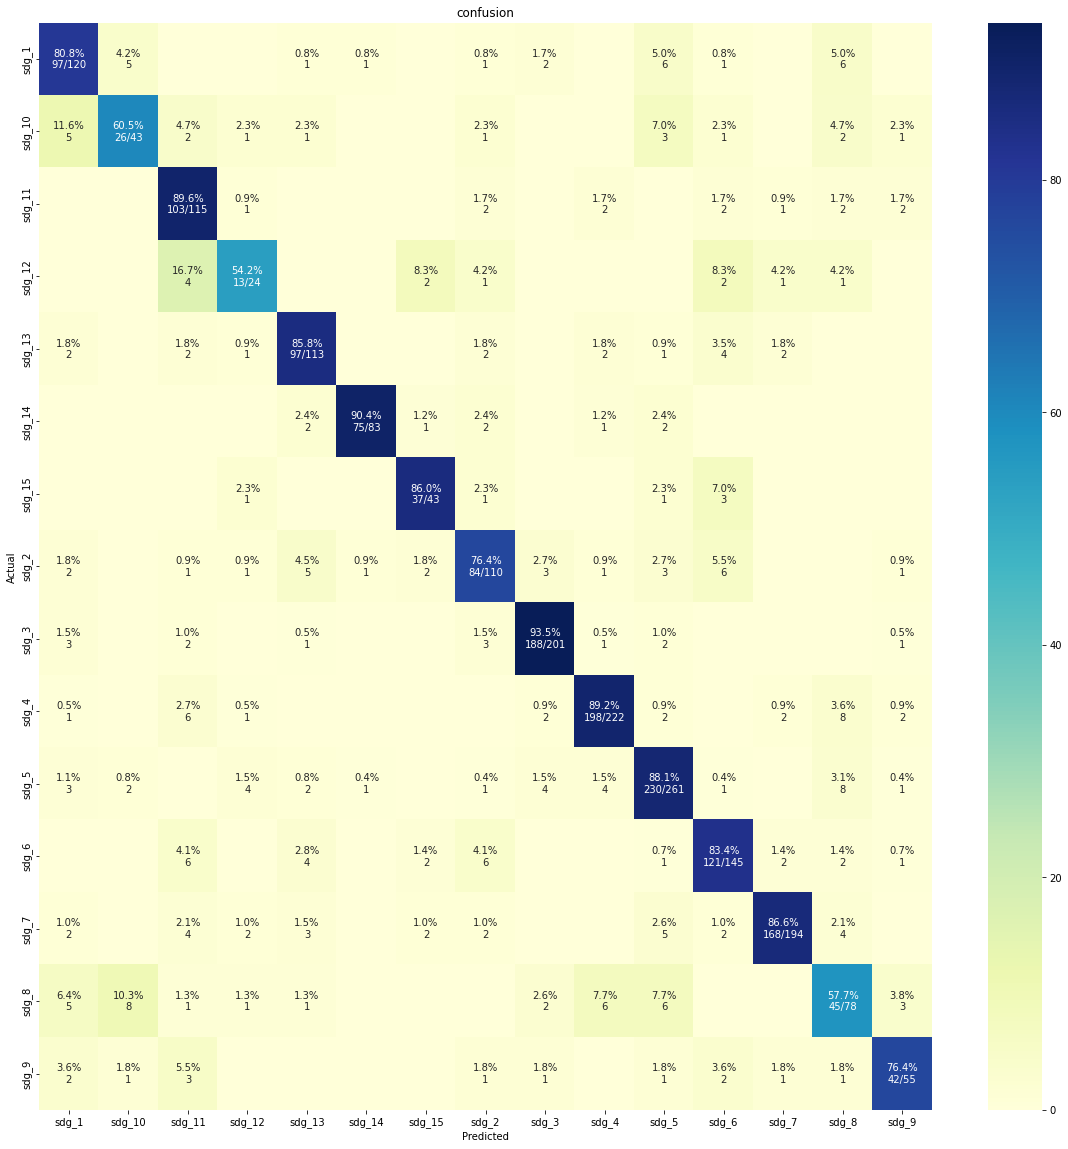

In [ ]:
conmpute_confusion_matrix(pred[0], labels)

In [ ]:
predictions = np.argmax(pred[0], axis=1)
cm = confusion_matrix(labels, predictions, labels=np.unique(labels))
cm

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
predictions[0]

4

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 14.6 MB/s 
     |████████████████████████████████| 6.6 MB 50.8 MB/s 
     |████████████████████████████████| 596 kB 63.5 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import pipeline

pipe = pipeline("text-classification", model="jonas/sdg_classifier_osdg")


sdg_dict = {
'1':"SDG 1: End poverty in all its forms everywhere",
'2':"SDG 2: End hunger, achieve food security and improved nutrition and promote sustainable agriculture",
'3':"SDG3: Ensure healthy lives and promote well-being for all at all ages",
'4':"SDG 4: Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all",
'5':"SDG 5: Achieve gender equality and empower all women and girls",
'6':"SDG 6: Ensure availability and sustainable management of water and sanitation for all",
'7':"SDG 7: Ensure access to affordable, reliable, sustainable and modern energy for all",
'8':"SDG 8: Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all",
'9':"SDG 9: Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation",
'10':"SDG 10: Reduce inequality within and among countries",
'11':"SDG 11: Make cities and human settlements inclusive, safe, resilient and sustainable",
'12':"SDG 12: Ensure sustainable consumption and production patterns",
'13':"SDG 13: Take urgent action to combat climate change and its impacts*",
'14':"SDG 14: Conserve and sustainably use the oceans, seas and marine resources for sustainable development",
'15':"SDG 15: Protect, restore and promote sustainable use of terrestrial ecosystems, sustainably manage forests, combat desertification, and halt and reverse land degradation and halt biodiversity loss"
}


In [ ]:


def predict(text):
    preds = pipe(text)[0]

    return sdg_dict[preds["label"]], str(round(preds["score"], 5)*100) + " %"
    ##return sdg_dict[int(preds["label"][0])], str(round(preds["score"], 5)*100) + " %", sdg_dict[int(preds2["label"][0])], str(round(preds2["score"], 5)*100) + " %"


In [ ]:
a = predict('The Paris Agreement, adopted in 2015, aims to strengthen the global response to the threat of climate change by keeping a global temperature rise this century well below 2 degrees Celsius above pre-industrial levels. The agreement also aims to strengthen the ability of countries to deal with the impacts of climate change, through appropriate financial flows, a new technology framework and an enhanced capacity building framework.')

In [ ]:
a

('SDG 13: Take urgent action to combat climate change and its impacts*',
 '96.38 %')

In [ ]:
int(a[0])

13

In [11]:
df_osdg['text'].iloc[1]

'Labour legislation regulates maximum working hours, industrial safety, minimum wages and benefits for workers and the prevention of child labour, but enforcement, if any, is weak. Therefore, the immigration laws applicable in Western countries cannot be applied to these workers. T. H. including basic public services. ,,'

# Domain Adaptation

In [ ]:
from spacy.lang.en import English
nlp = English()
nlp.add_pipe('sentencizer')

text= ' '.join([tex for tex in list(df_osdg['text'])]) #.iloc[1]
doc = nlp(text)

sents_list = []
for sent in doc.sents:
   sents_list.append(sent.text)

print(len(sents_list))


In [50]:
!pip install sentence-transformers==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120748 sha256=81eda39c5ee95be65ca023df96b3e90e4c7c333e1473807aa90e9f4145880067
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.2
    Uninstalling sentence-transformers-2.2.2:
      Successfully uninstalled sentence-transformers-2.2.2


In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader

# Define your sentence transformer model using CLS pooling
model_name = 'bert-base-uncased'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Define a list with sentences (1k - 100k sentences)
train_sentences = list(df_osdg['text'])

# Create the special denoising dataset that adds noise on-the-fly
train_dataset = datasets.DenoisingAutoEncoderDataset(train_sentences)

# DataLoader to batch your data
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Use the denoising auto-encoder loss
train_loss = losses.DenoisingAutoEncoderLoss(model, decoder_name_or_path=model_name, tie_encoder_decoder=True)

# Call the fit method
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': 3e-5},
    show_progress_bar=True
)

model.save('output/tsdae-model')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relatio

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4015 [00:00<?, ?it/s]

In [51]:
!pip install huggingface_hub
!huggingface-cli login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) y
Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [53]:
from sentence_transformers import SentenceTransformer

# Load or train a model
#model.save_to_hub("sdg_sentence_transformer")
model.save_to_hub(repo_name="peter2000/sdg_sentence_transformer", train_datasets=["Filippo/osdg_cd"])

TypeError: ignored

In [25]:
model.push_to_hub('bert_sdg_adapted')

AttributeError: ignored

In [26]:
example1 = "The most vulnerable countries are seeking ‘loss and damage’ compensation from the biggest polluters."                             
example2 = "COP27 opens amid compounding crises of war, warming and economic instability."

In [ ]:
example1 = "The most vulnerable countries are seeking ‘loss and damage’ compensation from the biggest polluters."                             
example2 = "COP27 opens amid compounding crises of war, warming and economic instability."

In [ ]:
example1 = "The most vulnerable countries are seeking ‘loss and damage’ compensation from the biggest polluters."                             
example2 = "COP27 opens amid compounding crises of war, warming and economic instability."

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [34]:
model_original = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [32]:
def similarity(x,y,model):
    document = [x ,y]
        
    #Encode paragraphs
    document_embeddings = model.encode(document , show_progress_bar=False)
    #Compute cosine similarity between labels sentences and paragraphs
    similarity_matrix = cosine_similarity(document_embeddings)

    print("Text similarity:", round(similarity_matrix[0][1]*100,2),"%")

In [33]:
similarity(example1 ,example2,model)

Text similarity: 61.61 %


In [35]:
similarity(example1 ,example2,model_original)

Text similarity: 25.43 %


In [54]:
!zip -r sdg_sentence_transformer.zip output/tsdae-model/

  adding: output/tsdae-model/ (stored 0%)
  adding: output/tsdae-model/tokenizer.json (deflated 71%)
  adding: output/tsdae-model/vocab.txt (deflated 53%)
  adding: output/tsdae-model/1_Pooling/ (stored 0%)
  adding: output/tsdae-model/1_Pooling/config.json (deflated 49%)
  adding: output/tsdae-model/sentence_bert_config.json (deflated 4%)
  adding: output/tsdae-model/config_sentence_transformers.json (deflated 26%)
  adding: output/tsdae-model/special_tokens_map.json (deflated 42%)
  adding: output/tsdae-model/config.json (deflated 48%)
  adding: output/tsdae-model/pytorch_model.bin (deflated 7%)
  adding: output/tsdae-model/tokenizer_config.json (deflated 41%)
  adding: output/tsdae-model/modules.json (deflated 53%)
  adding: output/tsdae-model/README.md (deflated 58%)
